In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from sklearn.model_selection import train_test_split

## Получение датасета.

До момента непосредственного создания модели, будем работать с pandas, как обеспечивающим большее удобство при анализе данных по сравнению с  numpy.

In [4]:
df = pd.read_csv("train.csv", index_col = 'Id')

In [5]:
df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
Id,,,,,,,,,,,,
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


Первичный анализ значений.

In [77]:
df.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


## Стандартные функции

Станадартизация и нормализация признаков.  
На практике в данном проекте применяем только стандартизацию.

In [ ]:
def standard_scale(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    return (X - mean) / std

In [ ]:
def norm(X):
    return (X - X.min()) / (X.max() - X.min())

## Функции случайного леса

Используем стандартную реализацию случайного леса, но адаптированную под возвращение вероятностей, а не значений классов.  
Мои изменения кода я старался выделить.

In [20]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [19]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [18]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

Изменение кода выделено 

In [17]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get) #need to be changed to probability
        #----------------------------------------------------------------------------
        target = max(classes.keys())
        number = classes.get(target)
        length = len(self.labels)                 
        prediction = number/length
        #-----------------------------------------------------------------------------
        return prediction  

In [16]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [15]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [14]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [9]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Изменение кода выделено

In [79]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        #-------------------------------------------------------------------------------------
        #voted_predictions.append(max(set(obj), key=obj.count)) #need to be changed to mean 
        voted_predictions.append(np.mean(obj))
        #--------------------------------------------------------------------------------------
    return voted_predictions

## Работа с датасетом.

In [22]:
y = df['choose']

In [26]:
X = df.drop(['choose'], axis = 1)

In [27]:
X.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
Id,,,,,,,,,,,
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0


In [28]:
y.head()

Id
0    0
1    1
2    0
3    1
4    0
Name: choose, dtype: int64

Стандартизация значений включая mean_exam_points

In [31]:
X = X.apply(standard_scale)

In [33]:
X

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
Id,,,,,,,,,,,
0,-1.345023,-1.117674,0.854466,0.345123,-0.767304,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,0.703552
1,0.771966,0.014262,-0.863783,0.345123,1.303134,-0.371874,2.744389,-0.250611,-0.168779,7.385804,-0.546906
2,-2.092195,0.580231,0.090800,-0.906684,1.303134,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,0.115101
3,-1.594080,0.580231,-1.245616,-0.906684,-0.767304,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,0.115101
4,0.024794,0.580231,1.045383,0.345123,1.303134,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,0.629995
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.145552,0.014262,0.854466,0.345123,1.303134,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,1.071333
9996,0.896495,0.014262,-0.672866,-0.906684,-0.767304,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,-0.399793
9997,-0.224264,1.712167,0.090800,-0.906684,-0.767304,-0.371874,-0.364343,-0.250611,-0.168779,7.385804,-0.399793


Построение boxplot.  
как иллюстрации

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


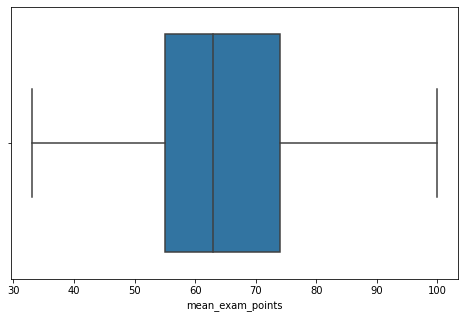

In [81]:
plt.figure(figsize=(8, 5))
sns.boxplot(df['mean_exam_points'])
plt.xlabel('mean_exam_points')
plt.show()

Построение матрицы корреляций. Видна очень высокая корреляция по нескольким параметрам.

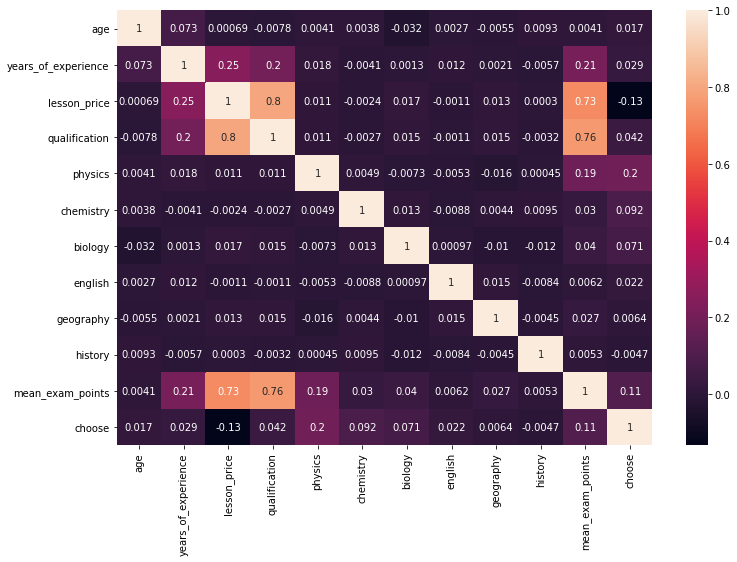

In [80]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Преобразование значений из pandas в numpy для последующей обработки деревом без необходимости его переработки.

In [34]:
X_np = X.to_numpy()
y_np = y.to_numpy()

In [30]:
def standard_scale(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    return (X - mean) / std

Функция оценки точности

In [42]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Разбивка датасета на ренировочный и тестовый.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.25)

Вычисление диапазона для деревьев для определения наилучшего количества  
В целом - не сильно полезно.

In [40]:
big_forest = np.linspace(1, 200, 20, dtype='int')

Перебор вариантов при обучении случайного леса.

In [43]:
%%time
results = []
for n_trees in big_forest:
    my_forest = random_forest(X_train, y_train, n_trees)
    y_train_pred = tree_vote(my_forest, X_train)
    y_test_pred = tree_vote(my_forest, X_test)
    train_accuracy = accuracy_metric(y_train, y_train_pred)
    test_accuracy = accuracy_metric(y_test, y_test_pred)
    results.append([n_trees, train_accuracy, test_accuracy])    

Wall time: 43min 29s


In [45]:
result_np = np.array(results)

Визуализация результатов

Text(0.5, 0, '200')

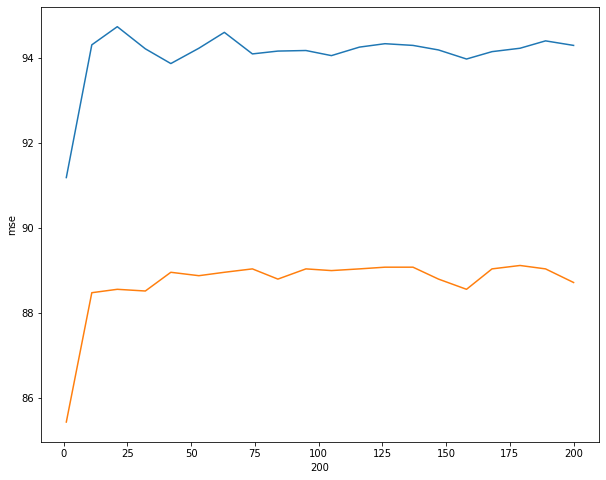

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(result_np[:, 0], result_np[:, 1], label = 'train')
plt.plot(result_np[:, 0], result_np[:, 2], label = 'test')
plt.ylabel("mse")
plt.xlabel(n_trees)

Обучение леса на полном датасете с максимальным количеством деревьев.

In [59]:
%%time
my_forest = random_forest(X_np, y_np, 200)

Wall time: 5min 1s


## Работа с валидационным датасетом.

Т.к. случайный лес показал достаточно высокий результат без всяких манипуляций с данными, то обработка датасета не является необходимлй сейчас.  
Единственное преобразование, как и в случае с обучающим датасетом - преобразование в numpy и последующая стандартизация.

In [60]:
df_valid = pd.read_csv("test.csv",index_col = 'Id')

In [61]:
X_valid = df_valid.apply(standard_scale)

In [62]:
X_valid_np = X_valid.to_numpy()

Получение предсказаний

In [63]:
y_pred = tree_vote(my_forest, X_valid_np)

In [64]:
y_pred

[0.3,
 0.49,
 0.16,
 0.295,
 0.39,
 0.64,
 0.11,
 0.52,
 0.13,
 0.45,
 0.38,
 0.08,
 0.135,
 0.145,
 0.565,
 0.19,
 0.075,
 0.29,
 0.33,
 0.435,
 0.41,
 0.755,
 0.16,
 0.12,
 0.53,
 0.12,
 0.375,
 0.165,
 0.275,
 0.19,
 0.72,
 0.255,
 0.38,
 0.265,
 0.27,
 0.175,
 0.22,
 0.15,
 0.39,
 0.08,
 0.22,
 0.325,
 0.28,
 0.09,
 0.24,
 0.295,
 0.605,
 0.63,
 0.135,
 0.305,
 0.54,
 0.375,
 0.34,
 0.17,
 0.47,
 0.115,
 0.375,
 0.185,
 0.165,
 0.285,
 0.46,
 0.075,
 0.47,
 0.6,
 0.53,
 0.55,
 0.2,
 0.275,
 0.14,
 0.1,
 0.255,
 0.185,
 0.595,
 0.31,
 0.42,
 0.425,
 0.255,
 0.35,
 0.13,
 0.605,
 0.39,
 0.165,
 0.475,
 0.39,
 0.565,
 0.115,
 0.56,
 0.075,
 0.17,
 0.235,
 0.11,
 0.11,
 0.55,
 0.175,
 0.55,
 0.355,
 0.205,
 0.19,
 0.31,
 0.17,
 0.145,
 0.72,
 0.5,
 0.16,
 0.25,
 0.11,
 0.43,
 0.29,
 0.3,
 0.43,
 0.305,
 0.35,
 0.105,
 0.2,
 0.1,
 0.29,
 0.1,
 0.51,
 0.48,
 0.355,
 0.23,
 0.285,
 0.35,
 0.08,
 0.41,
 0.21,
 0.295,
 0.08,
 0.4,
 0.555,
 0.285,
 0.105,
 0.42,
 0.115,
 0.55,
 0.275,
 0.23,

Получение индексов и последующая комбинация индексов и предсказаний.  
В случае pandas dataframe можно было бы использовать merdge команду, но в случае numpy приходится полагаться на порядок строк.

In [65]:
indeces = df_valid.index

In [67]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.rename(columns={0:'choose'}, inplace=True)

In [70]:
y_pred_df['Id'] = df_valid.index

In [74]:
y_pred_df.set_index(['Id'], drop=True, inplace=True)

Запись готового датасета в файл.

In [75]:
y_pred_df.to_csv('my_submission.csv')